In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve



import scipy.stats as stats

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


print('loaded')

loaded


In [2]:
def logistic_regression(X_train, X_test, y_train, y_test, C=100, max_iter=2500, penalty='l1', solver='saga'):
    
    print('Linear Regression')
    log_reg = LogisticRegression(C=C, max_iter=max_iter, penalty=penalty, solver=solver)
    log_reg.fit(X_train,y_train)
    print('The train accuracy score', log_reg.score(X_train,y_train))
    print('The test accuracy score', log_reg.score(X_test,y_test))

    log_reg_proba = log_reg.predict_proba(X_test)
    log_reg_proba_3 = log_reg_proba[:,1]

    print('')
    print('Classification Report for Logistic Regression model')
    print(classification_report(y_test, log_reg.predict(X_test)))

    plt.figure(figsize=(10, 5), dpi=100)

    cm = confusion_matrix(y_test, log_reg.predict(X_test))
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm, log_reg.classes_)
    plt.title('Logistic Regression Confusion Matrix')
    plt.show()
    return log_reg_proba_3

In [3]:
def random_forest_classifier(X_train, X_test, y_train, y_test,n_estimators=100, criterion='gini', max_features='sqrt', max_depth=10, n_jobs=2, random_state=17):
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion=criterion, 
                                max_features=max_features, 
                                max_depth=max_depth, 
                                n_jobs=n_jobs,
                                random_state=random_state)
    rf.fit(X_train,y_train)
    print('The train accuracy score', rf.score(X_train,y_train))
    print('The test accuracy score', rf.score(X_test,y_test))
    ran_for_proba = rf.predict_proba(X_test)
    ran_for_proba_3 = ran_for_proba[:,1]
    print('')
    print('Classification Report for Random Forest model')
    print(classification_report(y_test, rf.predict(X_test)))
    print(rf.classes_)

    plt.figure(figsize=(10, 5), dpi=100)
    cm2 = confusion_matrix(y_test, rf.predict(X_test))
    cm_norm2 = cm2 / cm2.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm2, rf.classes_)
    plt.title('Random Forest Confusion Matrix')
    
    plt.barh(X_train.columns[rf.feature_importances_.argsort()], rf.feature_importances_[rf.feature_importances_.argsort()])
    rounded = np.around(rf.feature_importances_,3)
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 15)
    bars = ax.barh(X_train.columns[rounded.argsort()], rounded[rounded.argsort()])
    ax.set_ylim(ax.get_ylim()[::1])
    ax.bar_label(bars)
    return ran_for_proba_3

In [4]:
def knn(X_train, X_test, y_train, y_test):
    knn_scores = []
    for k in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X_train, y_train, cv=10)
        knn_scores.append(score.mean())
    
    knn_scores = list(np.around(np.array(knn_scores),3))
    plt.figure(figsize=(20, 15), dpi=100)

    plt.plot([k for k in range(1,30)], knn_scores, color='blue')
    for i in range(1,30):
        plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
    plt.xticks([i for i in range(1,30)])
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Scores')
    plt.title('Scores of KNN Model for different K')
    
    x = knn_scores.index(max(knn_scores))
    
    print('Best K: ', x+1)
    
    knn2 = KNeighborsClassifier(n_neighbors=x+1)
    knn2.fit(X_train, y_train)
    knn2.predict(X_test)
    knn_proba = knn2.predict_proba(X_test)
    knn_proba_3 = knn_proba[:,1]
    print('The train accuracy score', knn2.score(X_train,y_train))
    print('The test accuracy score', knn2.score(X_test,y_test))
    print('')
    print('Classification Report for Test set')
    print(classification_report(y_test, knn2.predict(X_test)))

    plt.figure(figsize=(10, 5), dpi=100)
    cm3 = confusion_matrix(y_test, knn2.predict(X_test))
    cm_norm3 = cm3 / cm3.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm_norm3, knn2.classes_)
    plt.title('KNN Confusion Matrix')
    
    return knn_proba_3

In [51]:
def roccurve(y_test, log_reg_proba, rand_forest_proba, knn_proba):
    logistic_fpr, logistic_tpr, threshold_log = roc_curve(y_test, log_reg_proba)
    auc_logistic = auc(logistic_fpr, logistic_tpr)

    rf_fpr, rf_tpr, threshold_rf = roc_curve(y_test, rand_forest_proba)
    auc_rf = auc(rf_fpr, rf_tpr)

    knn_fpr, knn_tpr, threshold_knn = roc_curve(y_test, knn_proba)
    auc_knn = auc(knn_fpr, knn_tpr)

    accuracy_log_4 = []
    for thres in threshold_log:
        y_pred = np.where(log_reg_proba>thres,1,0)
        accuracy_log_4.append(accuracy_score(y_test, y_pred, normalize=True))

    accuracy_log_4 = pd.concat([pd.Series(threshold_log), pd.Series(accuracy_log_4)],
                            axis=1)
    accuracy_log_4.columns = ['thresholds', 'accuracy']
    accuracy_log_4.sort_values(by='accuracy', ascending=False, inplace=True)
    log_thresh_4 = accuracy_log_4['thresholds'].iloc[0]
    log_accuracy_4 = accuracy_log_4['accuracy'].iloc[0]

    accuracy_rf_4 = []
    for thres in threshold_rf:
        y_pred = np.where(rand_forest_proba>thres,1,0)
        accuracy_rf_4.append(accuracy_score(y_test, y_pred, normalize=True))

    accuracy_rf_4 = pd.concat([pd.Series(threshold_rf), pd.Series(accuracy_rf_4)],
                            axis=1)
    accuracy_rf_4.columns = ['thresholds', 'accuracy']
    accuracy_rf_4.sort_values(by='accuracy', ascending=False, inplace=True)
    rf_thresh_4 = accuracy_rf_4['thresholds'].iloc[0]
    rf_accuracy_4 = accuracy_rf_4['accuracy'].iloc[0]

    accuracy_knn_4 = []
    for thres in threshold_knn:
        y_pred = np.where(knn_proba>thres,1,0)
        accuracy_knn_4.append(accuracy_score(y_test, y_pred, normalize=True))

    accuracy_knn_4 = pd.concat([pd.Series(threshold_knn), pd.Series(accuracy_knn_4)],
                            axis=1)
    accuracy_knn_4.columns = ['thresholds', 'accuracy']
    accuracy_knn_4.sort_values(by='accuracy', ascending=False, inplace=True)
    knn_thresh_4 = accuracy_knn_4['thresholds'].iloc[0]
    
    if knn_thresh_4 > 1:
        knn_thresh_4 = abs(knn_thresh_4 - 1)
    knn_accuracy_4 = accuracy_knn_4['accuracy'].iloc[0]

    logistic_precision_4, logistic_recall_4, logistic_threshold_4 = precision_recall_curve(y_test, log_reg_proba)

    rf_precision_4, rf_recall_4, rf_threshold_4 = precision_recall_curve(y_test, rand_forest_proba)

    knn_precision_4, knn_recall_4, knn_threshold_4 = precision_recall_curve(y_test, knn_proba)
    
    fig, ax = plt.subplots(2, figsize=(15, 15))
    
    ax[0].plot(rf_fpr, rf_tpr, linestyle='-', label='RF (auc = %0.3f)' % auc_rf, color='blue')
    ax[0].plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic, color='orange')
    ax[0].plot(knn_fpr, knn_tpr, marker='x', label='KNN (auc = %0.3f)' % auc_knn, color='green')
    ax[0].set_xlabel('False Positive Rate -->')
    ax[0].set_ylabel('True Positive Rate -->')
    ax[0].legend()
    ax[0].set_title('ROC Curve')
#     plt.show()
    

    ax[1].plot(logistic_recall_4,logistic_precision_4, linestyle='-', label='Logistic', color='orange')
#     ax[1].axvline(x=log_thresh_4, color='orange', label='Optimal Logistic Regression Threshold (thres = %0.3f)' % (log_thresh_4))

    ax[1].plot(rf_recall_4,rf_precision_4, marker='.', label='RF', color='blue')
#     ax[1].axvline(x=rf_thresh_4, color='blue', label='Optimal Random Forest Threshold (thres = %0.3f)' % (rf_thresh_4))

    ax[1].plot(knn_recall_4,knn_precision_4, marker='x', label='KNN', color='green')
#     ax[1].axvline(x=knn_thresh_4, color='green', label='Optimal KNN Threshold (thres = %0.3f)' % (knn_thresh_4))
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend()


#     plt.show()


In [6]:
df = pd.read_csv('Data/ball_snap_data')
pd.set_option('display.max_columns', None)


In [7]:
# pd.set_option('display.max_rows',None)

In [8]:
df_copy2 = df.iloc[:,:].copy()
df_copy2

,gameId,playId,nflId,pff_role,pff_positionLinedUp,frameId,x,y,s,a,dis,o,dir,yardsToGo,passResult,prePenaltyPlayResult,offenseFormation,defendersInBox,dropBackType,pff_passCoverage,pff_passCoverageType,separation_from_defender,defender_from_ball,dist_from_ball,xcatchingReceiverRoute,ycatchingReceiverRoute
0,2021090900,97,35481.0,Pass Route,TE-L,6,41.65,29.34,1.20,1.78,0.10,78.97,63.46,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,3.030017,2.188995,5.420747,short,stop
1,2021090900,97,35634.0,Pass Route,LWR,6,41.04,36.77,0.48,2.61,0.04,113.75,54.53,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,2.706917,2.188995,12.860517,short,stop
2,2021090900,97,39985.0,Pass Route,HB-R,6,37.55,22.27,0.04,0.04,0.01,91.23,73.76,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,6.139422,2.188995,4.336196,short,stop
3,2021090900,97,41233.0,Pass Route,RWR,6,42.01,16.20,0.00,0.00,0.00,129.28,4.76,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,1.377679,2.188995,7.733104,short,stop
4,2021090900,97,44896.0,Pass Route,SLWR,6,40.16,35.09,2.98,1.93,0.31,120.74,169.40,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,4.278247,2.188995,11.257393,short,stop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38384,2021110100,4433,43425.0,Pass Route,HB-R,6,24.52,21.06,0.02,0.02,0.01,92.03,82.62,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,5.675077,2.455219,5.326800,short,stop
38385,2021110100,4433,44835.0,Pass Route,SLiWR,6,27.53,29.29,0.01,0.08,0.00,96.89,151.12,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,2.824606,2.455219,5.729311,short,stop
38386,2021110100,4433,47954.0,Pass Route,RWR,6,28.93,12.18,0.01,0.28,0.01,86.17,71.84,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,6.141010,2.455219,11.601246,short,stop
38387,2021110100,4433,52573.0,Pass Route,SLoWR,6,28.83,37.12,0.00,0.00,0.01,85.74,87.73,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,7.460670,2.455219,13.342732,short,stop


In [9]:
for index, row in df.iterrows():
    df1 = df[df['gameId'] == row['gameId']]
    df2 = df1[df1['playId'] == row['playId']]
    count_rec = df2['nflId'].shape[0]
    
    df_copy2.loc[index, 'receivers_count'] = count_rec
    
    for count in range(count_rec):
        df_copy2.loc[index, 'o_' + str(count)] = df2.iloc[count]['o']
        df_copy2.loc[index, 'dir_' + str(count)] = df2.iloc[count]['dir']
        df_copy2.loc[index, 'separation_from_defender_' + str(count)] = df2.iloc[count]['separation_from_defender']
        df_copy2.loc[index, 'dist_from_ball_' + str(count)] = df2.iloc[count]['dist_from_ball']
        df_copy2.loc[index, 'xcatchingReceiverRoute_' + str(count)] = df2.iloc[count]['xcatchingReceiverRoute']
        df_copy2.loc[index, 'ycatchingReceiverRoute_' + str(count)] = df2.iloc[count]['ycatchingReceiverRoute']
            
df_copy2           

,gameId,playId,nflId,pff_role,pff_positionLinedUp,frameId,x,y,s,a,dis,o,dir,yardsToGo,passResult,prePenaltyPlayResult,offenseFormation,defendersInBox,dropBackType,pff_passCoverage,pff_passCoverageType,separation_from_defender,defender_from_ball,dist_from_ball,xcatchingReceiverRoute,ycatchingReceiverRoute,receivers_count,o_0,dir_0,separation_from_defender_0,dist_from_ball_0,xcatchingReceiverRoute_0,ycatchingReceiverRoute_0,o_1,dir_1,separation_from_defender_1,dist_from_ball_1,xcatchingReceiverRoute_1,ycatchingReceiverRoute_1,o_2,dir_2,separation_from_defender_2,dist_from_ball_2,xcatchingReceiverRoute_2,ycatchingReceiverRoute_2,o_3,dir_3,separation_from_defender_3,dist_from_ball_3,xcatchingReceiverRoute_3,ycatchingReceiverRoute_3,o_4,dir_4,separation_from_defender_4,dist_from_ball_4,xcatchingReceiverRoute_4,ycatchingReceiverRoute_4
0,2021090900,97,35481.0,Pass Route,TE-L,6,41.65,29.34,1.20,1.78,0.10,78.97,63.46,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,3.030017,2.188995,5.420747,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
1,2021090900,97,35634.0,Pass Route,LWR,6,41.04,36.77,0.48,2.61,0.04,113.75,54.53,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,2.706917,2.188995,12.860517,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
2,2021090900,97,39985.0,Pass Route,HB-R,6,37.55,22.27,0.04,0.04,0.01,91.23,73.76,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,6.139422,2.188995,4.336196,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
3,2021090900,97,41233.0,Pass Route,RWR,6,42.01,16.20,0.00,0.00,0.00,129.28,4.76,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,1.377679,2.188995,7.733104,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
4,2021090900,97,44896.0,Pass Route,SLWR,6,40.16,35.09,2.98,1.93,0.31,120.74,169.40,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,4.278247,2.188995,11.257393,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38384,2021110100,4433,43425.0,Pass Route,HB-R,6,24.52,21.06,0.02,0.02,0.01,92.03,82.62,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,5.675077,2.455219,5.326800,short,stop,5.0,92.03,82.62,5.675077,5.326800,short,stop,96.89,151.12,2.824606,5.729311,short,stop,86.17,71.84,6.141010,11.601246,short,stop,85.74,87.73,7.460670,13.342732,short,stop,90.88,12.31,11.243496,18.177692,short,stop
38385,2021110100,4433,44835.0,Pass Route,SLiWR,6,27.53,29.29,0.01,0.08,0.00,96.89,151.12,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,2.824606,2.455219,5.729311,short,stop,5.0,92.03,82.62,5.675077,5.326800,short,stop,96.89,151.12,2.824606,5.729311,short,stop,86.17,71.84,6.141010,11.601246,short,stop,85.74,87.73,7.460670,13.342732,short,stop,90.88,12.31,11.243496,18.177692,short,stop
38386,2021110100,4433,47954.0,Pass Route,RWR,6,28.93,12.18,0.01,0.28,0.01,86.17,71.84,15,S,-5,SHOTGUN,6.0,TRADITIONAL,Quarters,Zone,6.141010,2.455219,11.601246,short,stop,5.0,92.03,82.62,5.675077,5.326800,short,stop,96.89,151.12,2.824606,5.729311,short,stop,86.17,71.84,6.1410

In [10]:
df_copy3 = df_copy2.drop_duplicates(subset=['gameId', 'playId'], keep='first')
df_copy3

,gameId,playId,nflId,pff_role,pff_positionLinedUp,frameId,x,y,s,a,dis,o,dir,yardsToGo,passResult,prePenaltyPlayResult,offenseFormation,defendersInBox,dropBackType,pff_passCoverage,pff_passCoverageType,separation_from_defender,defender_from_ball,dist_from_ball,xcatchingReceiverRoute,ycatchingReceiverRoute,receivers_count,o_0,dir_0,separation_from_defender_0,dist_from_ball_0,xcatchingReceiverRoute_0,ycatchingReceiverRoute_0,o_1,dir_1,separation_from_defender_1,dist_from_ball_1,xcatchingReceiverRoute_1,ycatchingReceiverRoute_1,o_2,dir_2,separation_from_defender_2,dist_from_ball_2,xcatchingReceiverRoute_2,ycatchingReceiverRoute_2,o_3,dir_3,separation_from_defender_3,dist_from_ball_3,xcatchingReceiverRoute_3,ycatchingReceiverRoute_3,o_4,dir_4,separation_from_defender_4,dist_from_ball_4,xcatchingReceiverRoute_4,ycatchingReceiverRoute_4
0,2021090900,97,35481.0,Pass Route,TE-L,6,41.65,29.34,1.20,1.78,0.10,78.97,63.46,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,3.030017,2.188995,5.420747,short,stop,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop
5,2021090900,137,42347.0,Pass Route,SLWR,6,109.39,13.78,0.25,0.16,0.03,110.58,22.12,10,C,28,EMPTY,6.0,TRADITIONAL,Cover-3,Zone,3.717324,1.325934,10.181773,short,stop,5.0,110.58,22.12,3.717324,10.181773,short,stop,335.16,342.93,11.264546,20.360327,short,stop,305.34,246.03,5.564108,11.845649,short,stop,145.03,268.76,3.817080,7.635738,short,stop,257.77,250.31,4.074126,16.349670,short,stop
10,2021090900,187,42347.0,Pass Route,RWR,6,78.72,37.43,0.54,2.00,0.05,243.15,286.39,6,C,5,SHOTGUN,6.0,TRADITIONAL,Cover-3,Zone,6.364535,2.947830,11.051774,short,stop,5.0,243.15,286.39,6.364535,11.051774,short,stop,272.60,213.26,3.466021,7.680059,short,stop,178.04,178.13,7.609074,16.591787,short,stop,288.09,267.12,2.167602,4.912321,short,stop,284.09,337.52,5.722971,4.089523,short,stop
15,2021090900,282,42347.0,Pass Route,SLWR,6,50.05,19.25,0.00,0.00,0.01,92.57,287.27,10,I,0,SINGLEBACK,6.0,TRADITIONAL,Cover-3,Zone,2.316635,2.005243,10.550929,short,stop,3.0,92.57,287.27,2.316635,10.550929,short,stop,227.88,196.16,8.587258,6.934876,short,stop,276.69,276.19,4.554317,12.835205,short,stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2021090900,349,42347.0,Pass Route,RWR,6,56.77,38.73,0.01,0.01,0.01,357.97,127.84,15,I,0,SHOTGUN,7.0,TRADITIONAL,Cover-3,Zone,3.656241,0.972934,9.300538,short,stop,4.0,357.97,127.84,3.656241,9.300538,short,stop,248.76,256.02,9.962670,21.019707,short,stop,193.56,130.55,2.124618,4.745872,short,stop,266.98,326.31,5.220278,11.900000,short,stop,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38365,2021110100,4310,39646.0,Pass Route,RWR,6,18.90,47.67,0.00,0.00,0.00,241.60,356.52,8,S,-8,SHOTGUN,4.0,SCRAMBLE,Bracket,Other,2.012014,2.622308,17.764887,short,stop,5.0,241.60,356.52,2.012014,17.764887,short,stop,255.96,312.27,3.349284,7.814922,short,stop,265.99,256.08,4.969034,12.499620,short,stop,274.89,88.55,1.991231,20.239884,short,stop,265.42,347.35,6.063827,5.700746,short,stop
38370,2021110100,4363,43425.0,Pass Route,HB-L,6,29.63,32.28,0.00,0.00,0.00,78.14,26.25,10,C,3,SHOTGUN,5.0,SCRAMBLE,Cover-2,Zone,5.773872,2.481955,5.783926,short,stop,5.0,78.14,26.25,5.773872,5.783926,short,stop,105.76,39.47,2.053607,5.892504,short,stop,85.07,88.60,3.599347,8.782312,short,stop,71.18,137.03,5.450110,12.313996,short,stop,89.97,154.20,2.545781,21.185922,short,stop
38375,2021110100,4392,43425.0,Pass Route,HB-R,6,32.64,21.64,0.01,0.01,0.01,87.58,256.14,7,S,-8,SHOTGUN,6.0,TRADITIONAL,Cover-2,Zone,5.819364,2.501220,5.698991,short,stop,5.0,87.58,256.14,5.819364,5.698991,short,stop,98.84,112.85,2.361906,7.260062,short,stop,74.91,92.88,1.971319,15.541

In [11]:
df_copy4 = df_copy3.drop(columns=['gameId','playId', 'nflId', 'pff_role', 'pff_positionLinedUp', 'frameId', 'x', 'y','s','a', 'dis', 'o', 'dir', 'separation_from_defender', 'dist_from_ball', 'xcatchingReceiverRoute', 'ycatchingReceiverRoute'])
df_copy4.dtypes

yardsToGo                       int64
passResult                     object
prePenaltyPlayResult            int64
offenseFormation               object
defendersInBox                float64
dropBackType                   object
pff_passCoverage               object
pff_passCoverageType           object
defender_from_ball            float64
receivers_count               float64
o_0                           float64
dir_0                         float64
separation_from_defender_0    float64
dist_from_ball_0              float64
xcatchingReceiverRoute_0       object
ycatchingReceiverRoute_0       object
o_1                           float64
dir_1                         float64
separation_from_defender_1    float64
dist_from_ball_1              float64
xcatchingReceiverRoute_1       object
ycatchingReceiverRoute_1       object
o_2                           float64
dir_2                         float64
separation_from_defender_2    float64
dist_from_ball_2              float64
xcatchingRec

In [12]:
df_copy4['first_down_achieved'] = np.where(
    df_copy4['yardsToGo'] > df_copy4['prePenaltyPlayResult'], 0, np.where(
        df_copy4['yardsToGo'] <= df_copy4['prePenaltyPlayResult'], 1, -1)
)
df_copy4

,yardsToGo,passResult,prePenaltyPlayResult,offenseFormation,defendersInBox,dropBackType,pff_passCoverage,pff_passCoverageType,defender_from_ball,receivers_count,o_0,dir_0,separation_from_defender_0,dist_from_ball_0,xcatchingReceiverRoute_0,ycatchingReceiverRoute_0,o_1,dir_1,separation_from_defender_1,dist_from_ball_1,xcatchingReceiverRoute_1,ycatchingReceiverRoute_1,o_2,dir_2,separation_from_defender_2,dist_from_ball_2,xcatchingReceiverRoute_2,ycatchingReceiverRoute_2,o_3,dir_3,separation_from_defender_3,dist_from_ball_3,xcatchingReceiverRoute_3,ycatchingReceiverRoute_3,o_4,dir_4,separation_from_defender_4,dist_from_ball_4,xcatchingReceiverRoute_4,ycatchingReceiverRoute_4,first_down_achieved
0,2,I,0,SHOTGUN,6.0,TRADITIONAL,Cover-1,Man,2.188995,5.0,78.97,63.46,3.030017,5.420747,short,stop,113.75,54.53,2.706917,12.860517,short,stop,91.23,73.76,6.139422,4.336196,short,stop,129.28,4.76,1.377679,7.733104,short,stop,120.74,169.40,4.278247,11.257393,short,stop,0
5,10,C,28,EMPTY,6.0,TRADITIONAL,Cover-3,Zone,1.325934,5.0,110.58,22.12,3.717324,10.181773,short,stop,335.16,342.93,11.264546,20.360327,short,stop,305.34,246.03,5.564108,11.845649,short,stop,145.03,268.76,3.817080,7.635738,short,stop,257.77,250.31,4.074126,16.349670,short,stop,1
10,6,C,5,SHOTGUN,6.0,TRADITIONAL,Cover-3,Zone,2.947830,5.0,243.15,286.39,6.364535,11.051774,short,stop,272.60,213.26,3.466021,7.680059,short,stop,178.04,178.13,7.609074,16.591787,short,stop,288.09,267.12,2.167602,4.912321,short,stop,284.09,337.52,5.722971,4.089523,short,stop,0
15,10,I,0,SINGLEBACK,6.0,TRADITIONAL,Cover-3,Zone,2.005243,3.0,92.57,287.27,2.316635,10.550929,short,stop,227.88,196.16,8.587258,6.934876,short,stop,276.69,276.19,4.554317,12.835205,short,stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
18,15,I,0,SHOTGUN,7.0,TRADITIONAL,Cover-3,Zone,0.972934,4.0,357.97,127.84,3.656241,9.300538,short,stop,248.76,256.02,9.962670,21.019707,short,stop,193.56,130.55,2.124618,4.745872,short,stop,266.98,326.31,5.220278,11.900000,short,stop,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38365,8,S,-8,SHOTGUN,4.0,SCRAMBLE,Bracket,Other,2.622308,5.0,241.60,356.52,2.012014,17.764887,short,stop,255.96,312.27,3.349284,7.814922,short,stop,265.99,256.08,4.969034,12.499620,short,stop,274.89,88.55,1.991231,20.239884,short,stop,265.42,347.35,6.063827,5.700746,short,stop,0
38370,10,C,3,SHOTGUN,5.0,SCRAMBLE,Cover-2,Zone,2.481955,5.0,78.14,26.25,5.773872,5.783926,short,stop,105.76,39.47,2.053607,5.892504,short,stop,85.07,88.60,3.599347,8.782312,short,stop,71.18,137.03,5.450110,12.313996,short,stop,89.97,154.20,2.545781,21.185922,short,stop,0
38375,7,S,-8,SHOTGUN,6.0,TRADITIONAL,Cover-2,Zone,2.501220,5.0,87.58,256.14,5.819364,5.698991,short,stop,98.84,112.85,2.361906,7.260062,short,stop,74.91,92.88,1.971319,15.541136,short,stop,93.37,33.37,3.647862,23.453635,short,stop,95.43,112.43,7.562467,15.094138,short,stop,0
38380,15,I,0,SHOTGUN,5.0,TRADITIONAL,Cover-2,Zone,2.619656,4.0,88.81,105.35,3.034024,7.671408,short,stop,80.26,336.73,5.917314,11.854387,short,stop,100.82,283.88,4.637294,19.229997,short,stop,87.61,92.34,7.101605,11.618778,short,stop,NaN,NaN,NaN,NaN,NaN,NaN,0


In [13]:
df_copy4.describe()

,yardsToGo,prePenaltyPlayResult,defendersInBox,defender_from_ball,receivers_count,o_0,dir_0,separation_from_defender_0,dist_from_ball_0,o_1,dir_1,separation_from_defender_1,dist_from_ball_1,o_2,dir_2,separation_from_defender_2,dist_from_ball_2,o_3,dir_3,separation_from_defender_3,dist_from_ball_3,o_4,dir_4,separation_from_defender_4,dist_from_ball_4,first_down_achieved
count,8317.000000,8317.000000,8310.000000,8317.000000,8317.000000,8317.000000,8317.000000,8317.000000,8317.000000,8314.000000,8314.000000,8314.000000,8314.000000,8247.000000,8247.000000,8247.000000,8247.000000,7602.000000,7602.000000,7602.000000,7602.000000,5909.000000,5909.000000,5909.000000,5909.000000,8317.000000
mean,8.728027,6.537333,6.023345,1.589343,4.615727,181.123048,181.035097,4.233635,10.391350,181.111473,184.383518,4.352488,10.036773,182.846521,180.117766,4.311444,9.950635,181.157852,182.213852,4.510385,10.153398,180.836471,182.532291,4.680736,10.674826,0.342311
std,3.922512,10.184161,1.005310,0.659447,0.666654,92.373429,102.042295,2.123783,4.851218,92.744243,102.726641,2.121911,4.870901,93.266345,102.526700,2.140162,4.793190,93.326531,102.538690,2.147512,4.886382,92.878986,102.001614,2.159654,4.948678,0.474512
min,0.000000,-34.000000,1.000000,0.022361,1.000000,0.280000,0.100000,0.819878,2.104305,0.510000,0.000000,0.920869,1.606393,0.100000,0.010000,0.502195,1.209669,0.130000,0.060000,0.906091,2.280351,0.190000,0.060000,1.241692,2.116247,0.000000
25%,6.000000,0.000000,5.000000,1.132784,4.000000,89.590000,90.690000,2.540315,6.388623,89.352500,93.862500,2.578905,5.961705,89.280000,90.610000,2.557118,5.940715,88.870000,92.015000,2.690465,5.997866,88.380000,93.430000,2.819645,6.354188,0.000000
50%,10.000000,4.000000,6.000000,1.450552,5.000000,220.840000,183.820000,3.520511,9.187698,215.210000,186.365000,3.743408,8.771097,226.540000,180.930000,3.654942,8.662528,222.580000,184.075000,4.016248,8.754789,222.450000,184.310000,4.262065,9.469747,0.000000
75%,10.000000,10.000000,7.000000,1.884038,5.000000,268.620000,270.350000,5.670353,13.098996,268.907500,273.827500,5.809873,12.517316,269.910000,270.835000,5.805885,12.550596,268.840000,272.627500,5.992725,12.962649,268.630000,271.850000,6.136163,13.611807,1.000000
max,39.000000,91.000000,11.000000,6.493327,5.000000,359.880000,359.980000,16.092557,25.106322,359.900000,359.980000,12.304552,23.912173,359.790000,359.920000,15.201069,24.705200,360.000000,359.920000,14.040057,25.388667,359.500000,359.950000,15.959402,25.819204,1.000000


In [14]:
df_copy4.to_csv('Data/final_dataset', index=False)

In [15]:
df_rec_3 = df_copy4[df_copy4['receivers_count'] == 3]
df_rec_4 = df_copy4[df_copy4['receivers_count'] == 4]
df_rec_5 = df_copy4[df_copy4['receivers_count'] == 5]

In [16]:
df_rec_3_features = ['offenseFormation', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType','xcatchingReceiverRoute_0', 'ycatchingReceiverRoute_0','xcatchingReceiverRoute_1', 'ycatchingReceiverRoute_1','xcatchingReceiverRoute_2', 'ycatchingReceiverRoute_2']
df_rec_3_drop = ['o_3', 'dir_3','receivers_count',
       'separation_from_defender_3', 'dist_from_ball_3',
       'xcatchingReceiverRoute_3', 'ycatchingReceiverRoute_3', 'o_4', 'dir_4',
       'separation_from_defender_4', 'dist_from_ball_4',
       'xcatchingReceiverRoute_4', 'ycatchingReceiverRoute_4', 'passResult']
df_rec_4_features = [ 'offenseFormation', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType','xcatchingReceiverRoute_0', 'ycatchingReceiverRoute_0','xcatchingReceiverRoute_1', 'ycatchingReceiverRoute_1','xcatchingReceiverRoute_2', 'ycatchingReceiverRoute_2','xcatchingReceiverRoute_3', 'ycatchingReceiverRoute_3']
df_rec_4_drop = ['o_4', 'dir_4','receivers_count',
       'separation_from_defender_4', 'dist_from_ball_4',
       'xcatchingReceiverRoute_4', 'ycatchingReceiverRoute_4', 'passResult']
df_rec_5_features = ['offenseFormation', 'dropBackType', 'pff_passCoverage', 'pff_passCoverageType','xcatchingReceiverRoute_0', 'ycatchingReceiverRoute_0','xcatchingReceiverRoute_1', 'ycatchingReceiverRoute_1','xcatchingReceiverRoute_2', 'ycatchingReceiverRoute_2','xcatchingReceiverRoute_3', 'ycatchingReceiverRoute_3','xcatchingReceiverRoute_4', 'ycatchingReceiverRoute_4']
df_rec_5_drop = ['receivers_count', 'passResult']

In [17]:
df_3_receivers = df_rec_3.drop(columns=df_rec_3_drop, axis=1)
df_4_receivers = df_rec_4.drop(columns=df_rec_4_drop, axis=1)
df_5_receivers = df_rec_5.drop(columns=df_rec_5_drop, axis=1)

In [18]:
df_3_receivers = pd.get_dummies(df_3_receivers, columns = df_rec_3_features)
df_4_receivers = pd.get_dummies(df_4_receivers, columns = df_rec_4_features)
df_5_receivers = pd.get_dummies(df_5_receivers, columns = df_rec_5_features)

In [19]:
df_3_receivers = df_3_receivers[df_3_receivers['defendersInBox'].notna()]
df_4_receivers = df_4_receivers[df_4_receivers['defendersInBox'].notna()]
df_5_receivers = df_5_receivers[df_5_receivers['defendersInBox'].notna()]

In [20]:
df_3_receivers = df_3_receivers.drop(columns=['yardsToGo', 'prePenaltyPlayResult'], axis=1)
df_4_receivers = df_4_receivers.drop(columns=['yardsToGo', 'prePenaltyPlayResult'], axis=1)
df_5_receivers = df_5_receivers.drop(columns=['yardsToGo', 'prePenaltyPlayResult'], axis=1)

In [21]:
mms = MinMaxScaler()

def scaler(scaler, df, col_name, new_col_name):
    scaler.fit(df[[col_name]])
    df[new_col_name] = scaler.transform(df[[col_name]])

In [22]:
def cat_list(df):
    categorical_3 = df.columns.difference(df.select_dtypes('float64').columns).tolist()
    categorical_3.remove('first_down_achieved')
    categorical_3 = [s for s in categorical_3 if 'dropBack' not in s]
    categorical_3 = [s for s in categorical_3 if 'offenseFormation' not in s]
    categorical_3 = [s for s in categorical_3 if 'passResult' not in s]
    categorical_3 = [s for s in categorical_3 if 'pff_passCoverage' not in s]
    categorical_3 = [s for s in categorical_3 if 'xcatchingReceiverRoute' not in s]
    categorical_3 = [s for s in categorical_3 if 'ycatchingReceiverRoute' not in s]
    
    for col in categorical_3:
        scaler(mms, df_3_receivers, col, col + '_scaled')
        df.drop(col, axis=1, inplace=True)
    
    return df

In [23]:
df_3 = cat_list(df_3_receivers)
df_4 = cat_list(df_4_receivers)
df_5 = cat_list(df_5_receivers)

In [24]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
grid_params  = [
    {'solver' : ['saga'],
      'penalty' : [ 'l1', 'l2', 'none'],
      'max_iter' : [50,100,200,500,1000,2500, 5000],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'solver' : ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
      'penalty' : ['l2','none'],
      'max_iter' : [50,100,200,500,1000,2500, 5000],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
     {'solver' : ['liblinear'],
      'penalty' : ['l2','l1'],
      'max_iter' : [50,100,200,500,1000,2500, 5000],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ]

In [26]:
y_3 = df_3[['first_down_achieved']].values.ravel()
X_3 = df_3.drop('first_down_achieved', axis=1)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, random_state = 17, test_size = 0.3)

In [27]:
y_4 = df_4[['first_down_achieved']].values.ravel()
X_4 = df_4.drop('first_down_achieved', axis=1)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, random_state = 17, test_size = 0.3)

In [28]:
y_5 = df_5[['first_down_achieved']].values.ravel()
X_5 = df_5.drop('first_down_achieved', axis=1)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, random_state = 17, test_size = 0.3)

In [29]:
log_reg = LogisticRegression()
gscv = GridSearchCV(log_reg, param_grid = grid_params, cv=3, verbose=True, n_jobs=-1, error_score=0.0)
best_model = gscv.fit(X_train_3,y_train_3)
best_model.best_estimator_

Fitting 3 folds for each of 637 candidates, totalling 1911 fits


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (s

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklea

  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ra

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

LogisticRegression(C=0.001, max_iter=50, penalty='l1', solver='saga')

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Linear Regression
The train accuracy score 0.5977777777777777
The test accuracy score 0.5721649484536082

Classification Report for Logistic Regression model
              precision    recall  f1-score   support

           0       0.58      0.97      0.72       112
           1       0.40      0.02      0.05        82

    accuracy                           0.57       194
   macro avg       0.49      0.50      0.39       194
weighted avg       0.50      0.57      0.44       194



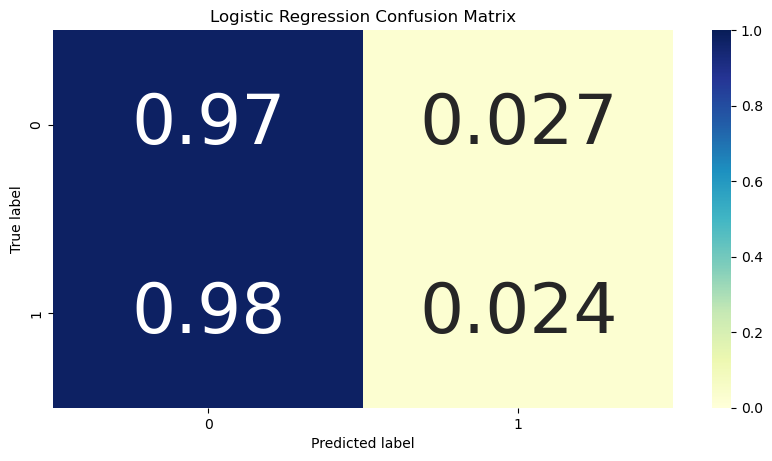

In [30]:
log_reg_3_proba = logistic_regression(X_train_3, X_test_3, y_train_3, y_test_3, 0.1, 1000, 'l1', 'saga')

In [31]:
log_reg = LogisticRegression()
gscv = GridSearchCV(log_reg, param_grid = grid_params, cv=3, verbose=True, n_jobs=-1, error_score=0.0)
best_model = gscv.fit(X_train_4,y_train_4)
best_model.best_estimator_

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 3 folds for each of 637 candidates, totalling 1911 fits


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/ba

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/an

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
294 fits failed out of a total of 1911.
The score on these train-test partiti

LogisticRegression(C=0.001, max_iter=50, penalty='l1', solver='saga')

Linear Regression
The train accuracy score 0.643279797125951
The test accuracy score 0.611439842209073

Classification Report for Logistic Regression model
              precision    recall  f1-score   support

           0       0.63      0.92      0.75       314
           1       0.46      0.11      0.18       193

    accuracy                           0.61       507
   macro avg       0.54      0.52      0.46       507
weighted avg       0.56      0.61      0.53       507



/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


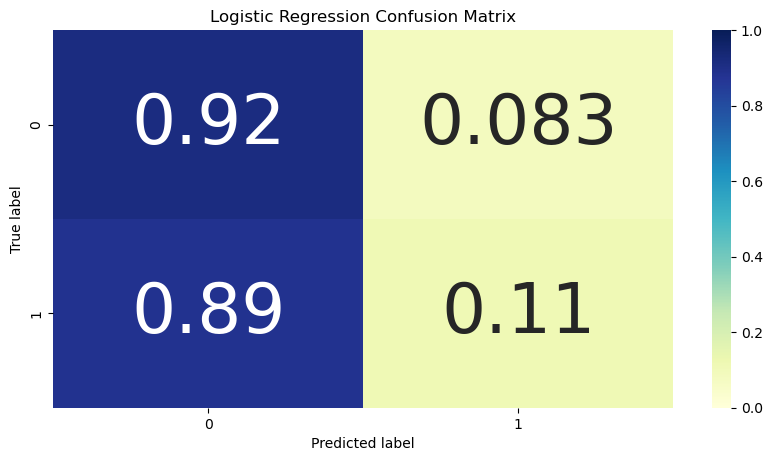

In [32]:
log_reg_4_proba = logistic_regression(X_train_4, X_test_4, y_train_4, y_test_4, C=1, max_iter=1000)

In [33]:
log_reg = LogisticRegression()
gscv = GridSearchCV(log_reg, param_grid = grid_params, cv=3, verbose=True, n_jobs=-1, error_score=0.0)
best_model = gscv.fit(X_train_5,y_train_5)
best_model.best_estimator_

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Fitting 3 folds for each of 637 candidates, totalling 1911 fits


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklea

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/skl

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/ba

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/

LogisticRegression(C=0.1)

Linear Regression
The train accuracy score 0.6727140783744557
The test accuracy score 0.6721218961625283

Classification Report for Logistic Regression model
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1191
           1       0.00      0.00      0.00       581

    accuracy                           0.67      1772
   macro avg       0.34      0.50      0.40      1772
weighted avg       0.45      0.67      0.54      1772



/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: 

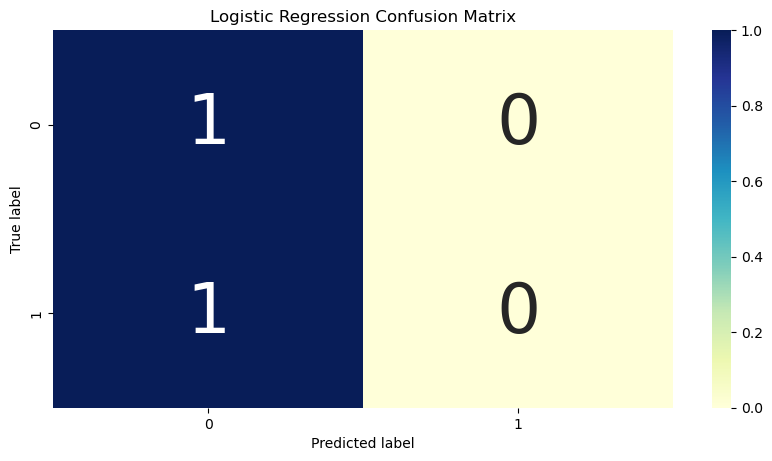

In [34]:
log_reg_5_proba = logistic_regression(X_train_5, X_test_5, y_train_5, y_test_5, C=10, max_iter=1000)

In [35]:
from itertools import product

n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='gini', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=17)
    rf.fit(X_train_3, y_train_3)
    prediction_test = rf.predict(X=X_test_3)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test_3,prediction_test)))    

Classification accuracy on test set with max features = 1 and max_depth = None: 0.546
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.577
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.577
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 6: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 7: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 8: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 9: 0.572
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.557
Classification accuracy on test set with max features = 1 and max_depth = 11: 0.546
Classification accuracy on test set with max features = 1 and max_depth = 12: 0.57

The train accuracy score 0.6222222222222222
The test accuracy score 0.5773195876288659

Classification Report for Random Forest model
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       112
           1       0.00      0.00      0.00        82

    accuracy                           0.58       194
   macro avg       0.29      0.50      0.37       194
weighted avg       0.33      0.58      0.42       194

[0 1]


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

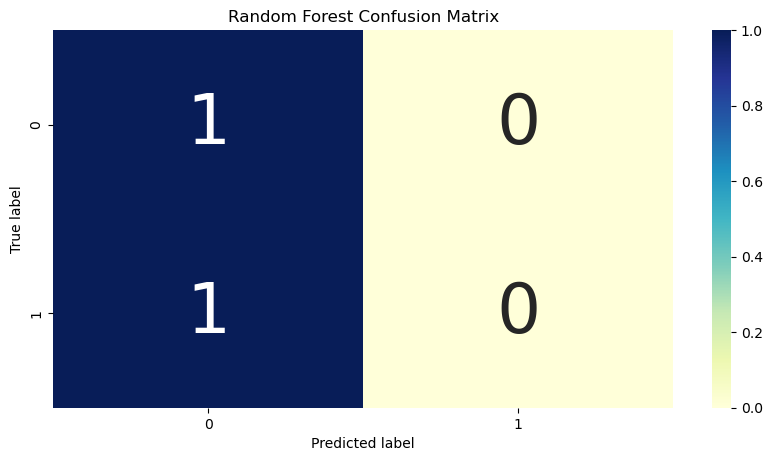

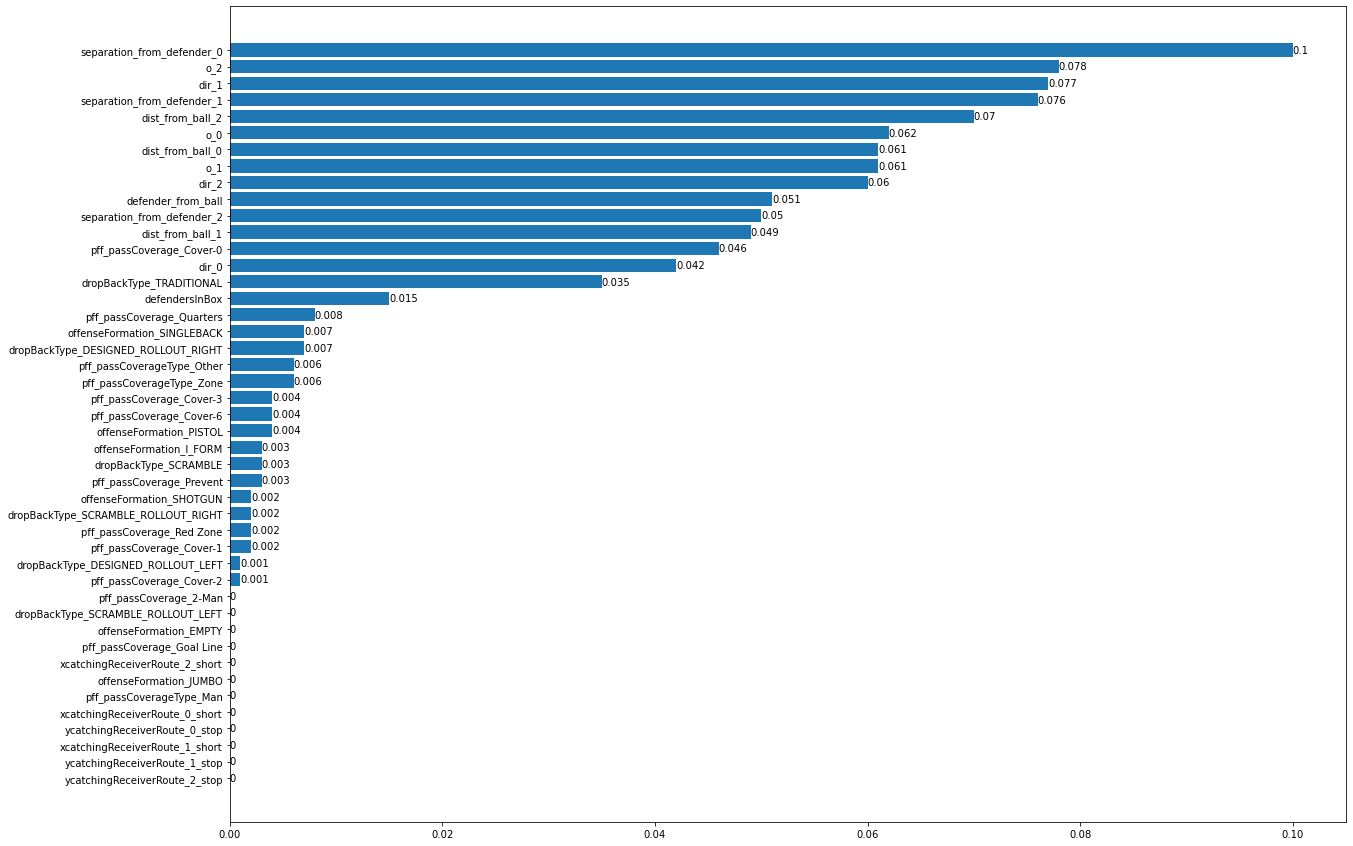

In [36]:
rand_forest_3_proba = random_forest_classifier(X_train_3, X_test_3, y_train_3, y_test_3,max_depth=3)

In [37]:
from itertools import product

n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='gini', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=17)
    rf.fit(X_train_4, y_train_4)
    prediction_test = rf.predict(X=X_test_4)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test_4,prediction_test)))    

Classification accuracy on test set with max features = 1 and max_depth = None: 0.617
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.619
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.619
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.621
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.621
Classification accuracy on test set with max features = 1 and max_depth = 6: 0.621
Classification accuracy on test set with max features = 1 and max_depth = 7: 0.621
Classification accuracy on test set with max features = 1 and max_depth = 8: 0.621
Classification accuracy on test set with max features = 1 and max_depth = 9: 0.623
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.619
Classification accuracy on test set with max features = 1 and max_depth = 11: 0.615
Classification accuracy on test set with max features = 1 and max_depth = 12: 0.61

The train accuracy score 0.727810650887574
The test accuracy score 0.6232741617357002

Classification Report for Random Forest model
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       314
           1       1.00      0.01      0.02       193

    accuracy                           0.62       507
   macro avg       0.81      0.51      0.39       507
weighted avg       0.77      0.62      0.48       507

[0 1]


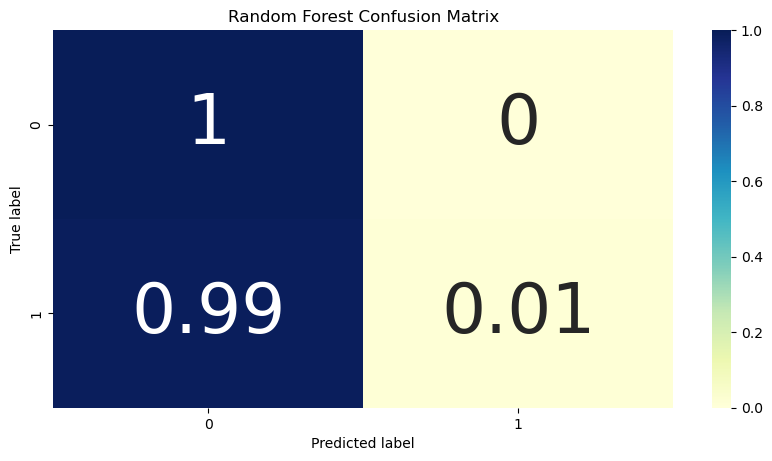

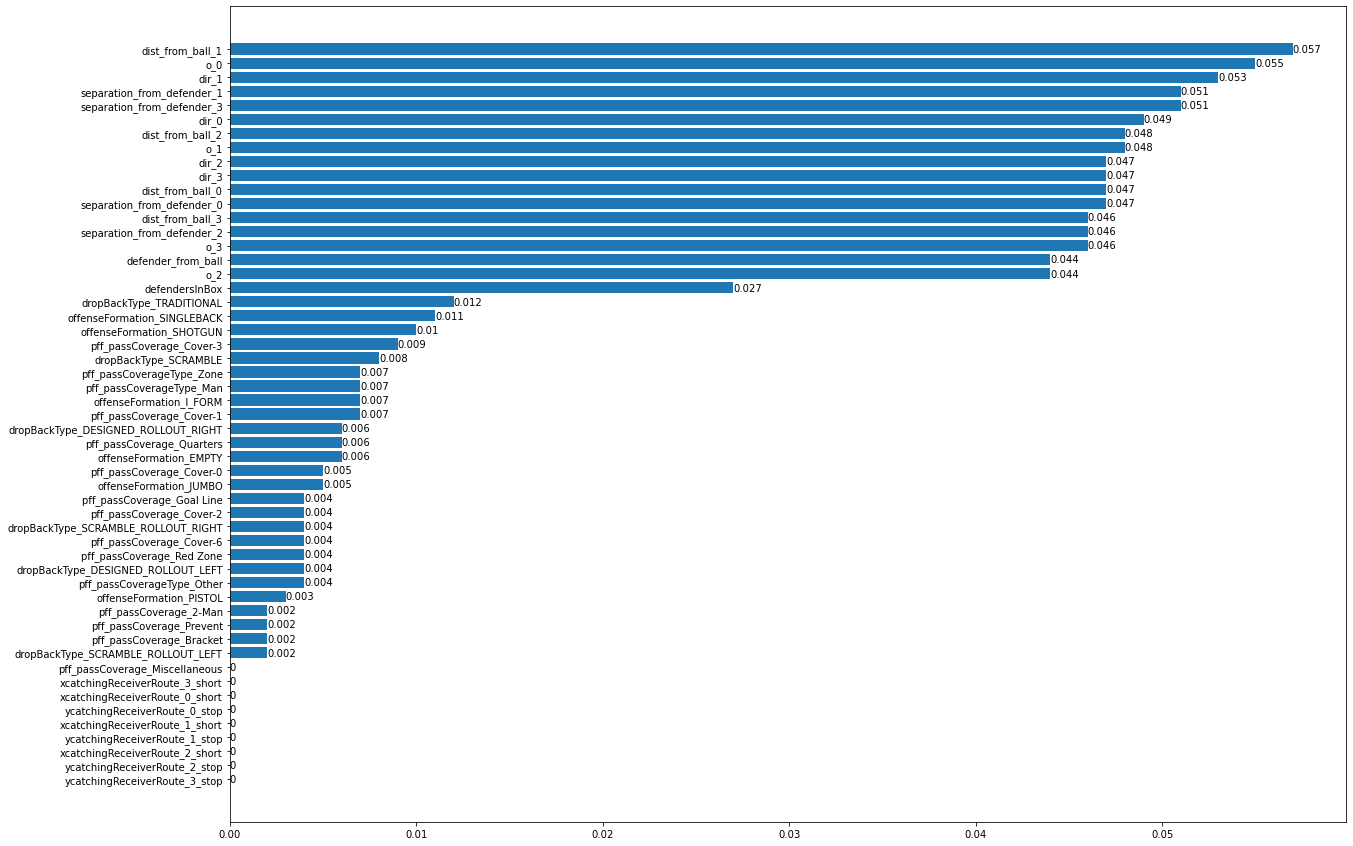

In [38]:
rand_forest_4_proba = random_forest_classifier(X_train_4, X_test_4, y_train_4, y_test_4,max_depth=9, max_features=1)

In [39]:
from itertools import product

n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='gini', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=17)
    rf.fit(X_train_5, y_train_5)
    prediction_test = rf.predict(X=X_test_5)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test_5,prediction_test)))    

Classification accuracy on test set with max features = 1 and max_depth = None: 0.666
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 6: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 7: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 8: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 9: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.672
Classification accuracy on test set with max features = 1 and max_depth = 11: 0.673
Classification accuracy on test set with max features = 1 and max_depth = 12: 0.67

The train accuracy score 0.7997097242380261
The test accuracy score 0.6721218961625283

Classification Report for Random Forest model
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1191
           1       0.50      0.01      0.02       581

    accuracy                           0.67      1772
   macro avg       0.59      0.50      0.41      1772
weighted avg       0.62      0.67      0.55      1772

[0 1]


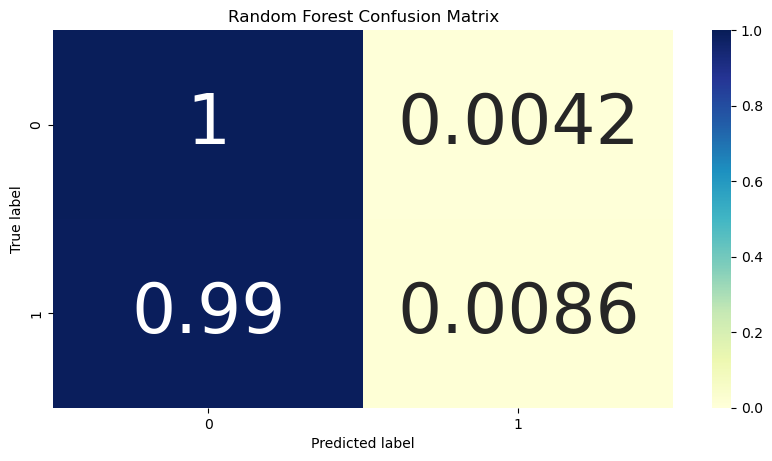

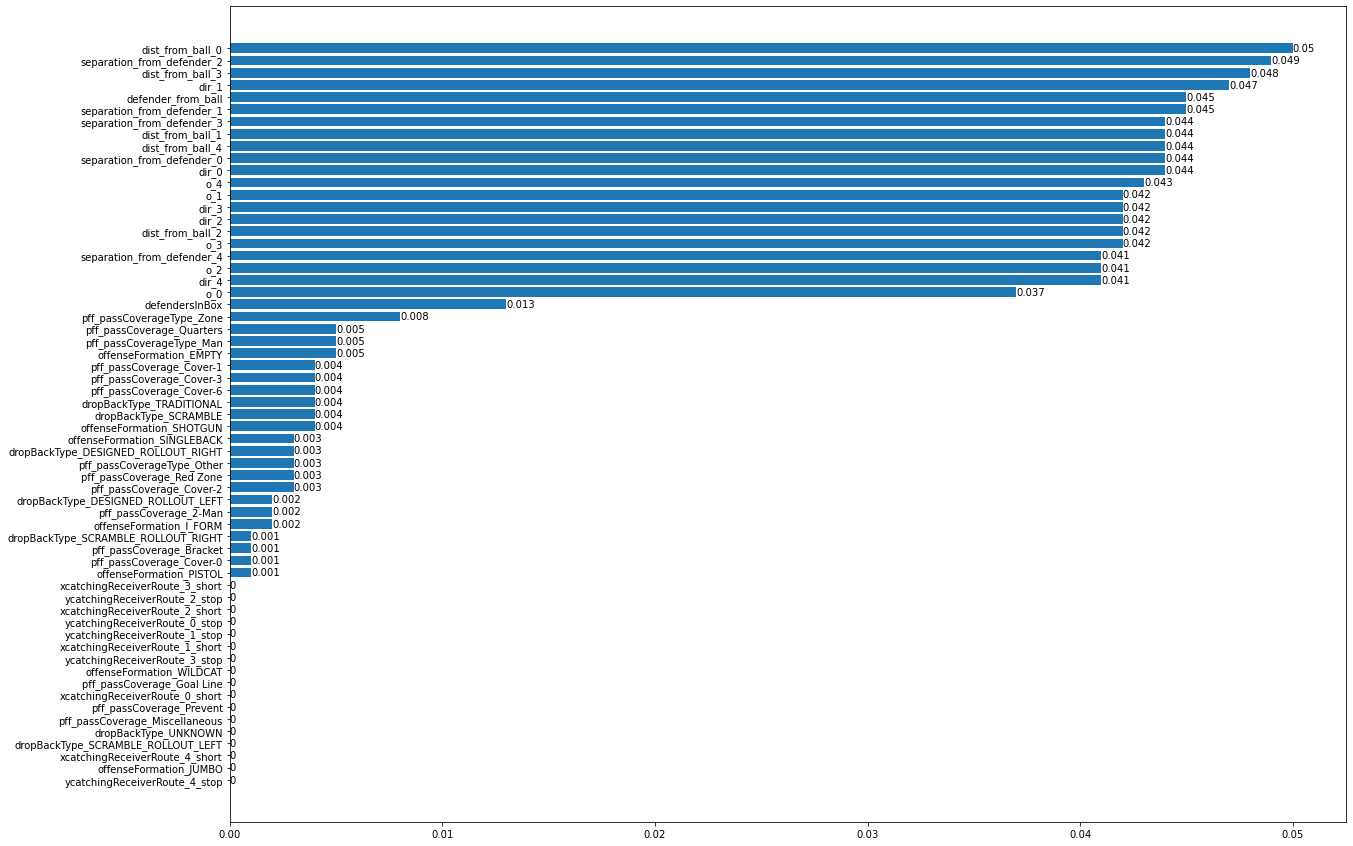

In [40]:
rand_forest_5_proba = random_forest_classifier(X_train_5, X_test_5, y_train_5, y_test_5,max_depth=12)

Best K:  29
The train accuracy score 0.6244444444444445
The test accuracy score 0.5824742268041238

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.59      0.90      0.71       112
           1       0.52      0.15      0.23        82

    accuracy                           0.58       194
   macro avg       0.56      0.52      0.47       194
weighted avg       0.56      0.58      0.51       194



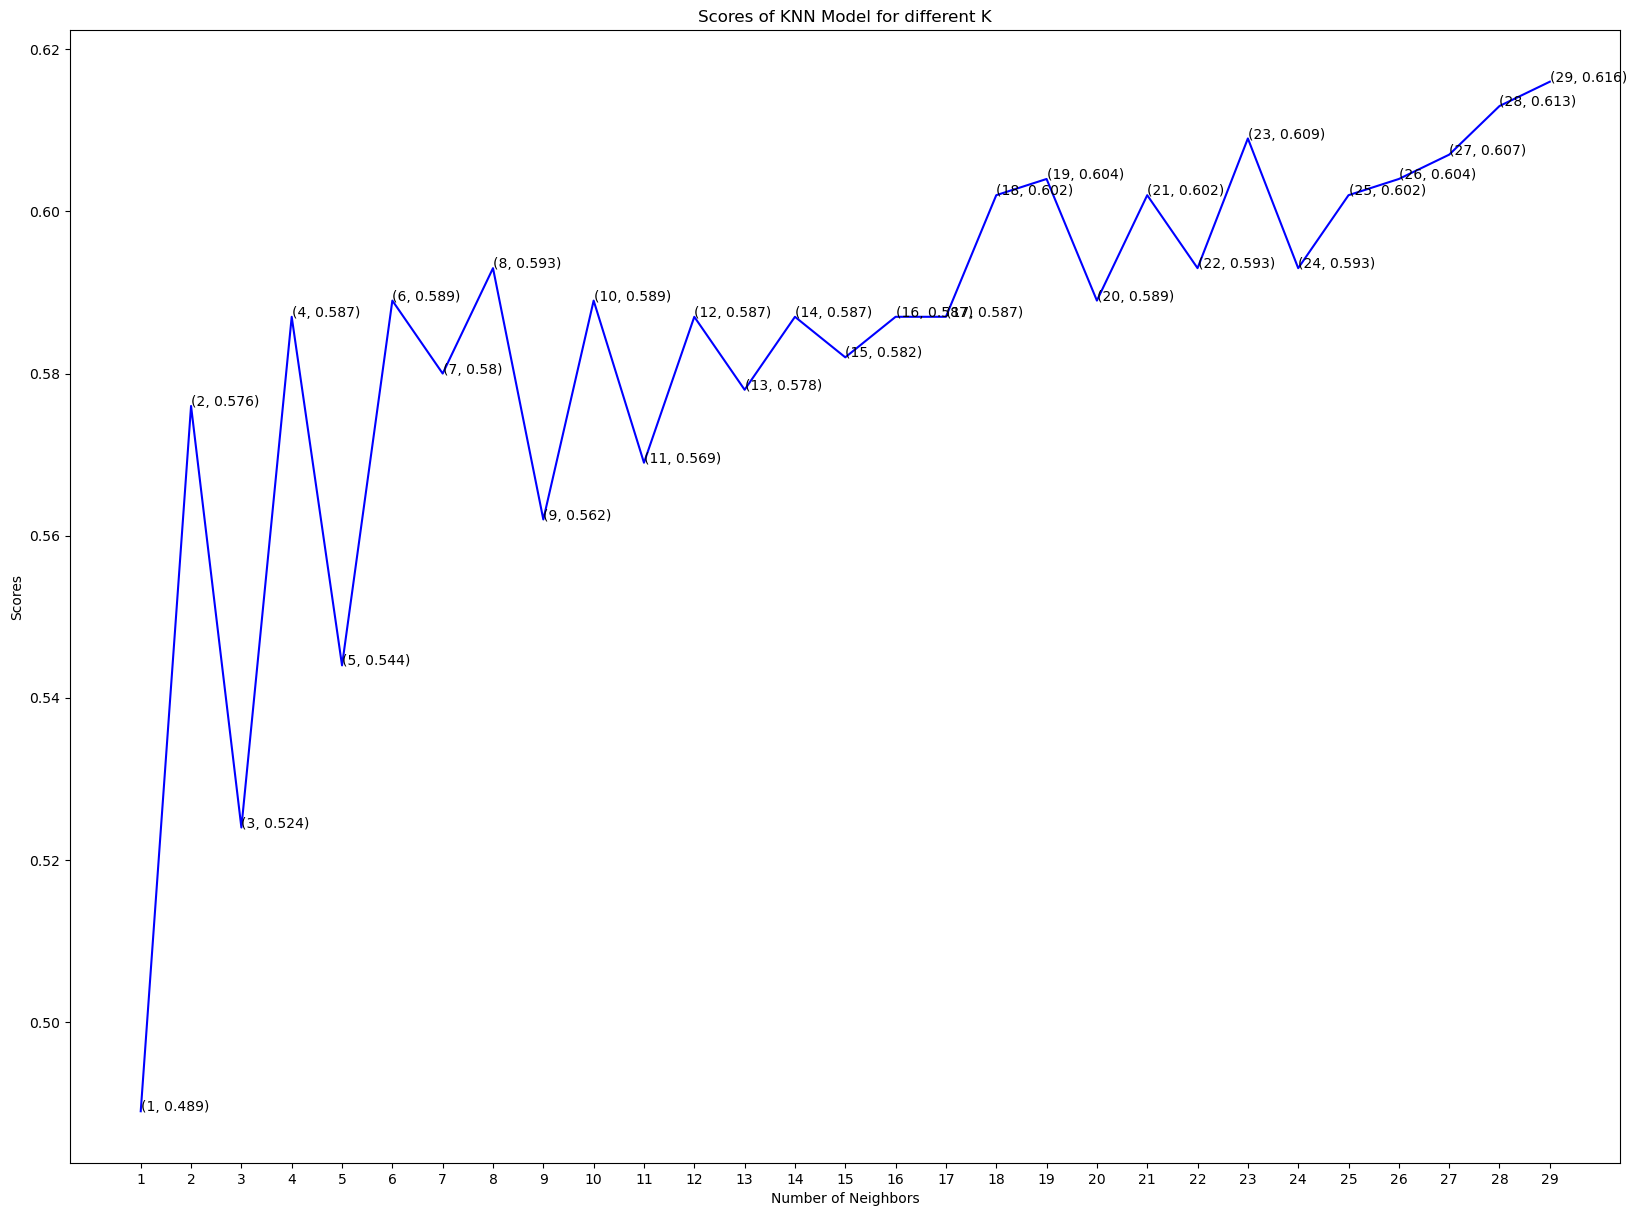

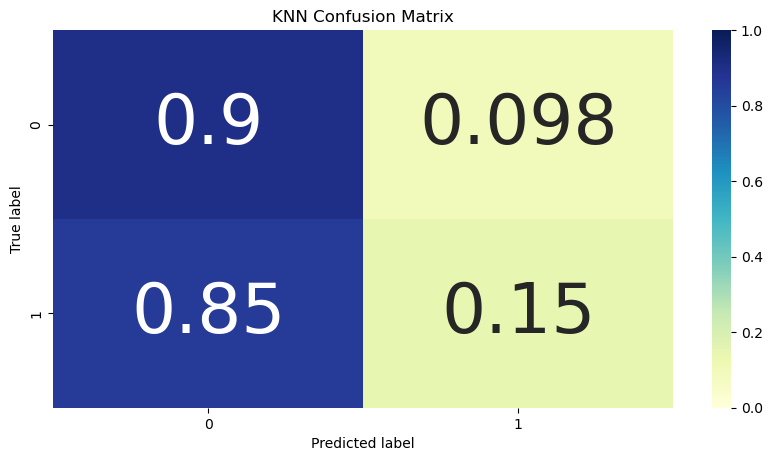

In [41]:
knn_3_proba = knn(X_train_3, X_test_3, y_train_3, y_test_3)

Best K:  22
The train accuracy score 0.6458157227387996
The test accuracy score 0.5857988165680473

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.61      0.91      0.73       314
           1       0.27      0.05      0.09       193

    accuracy                           0.59       507
   macro avg       0.44      0.48      0.41       507
weighted avg       0.48      0.59      0.49       507



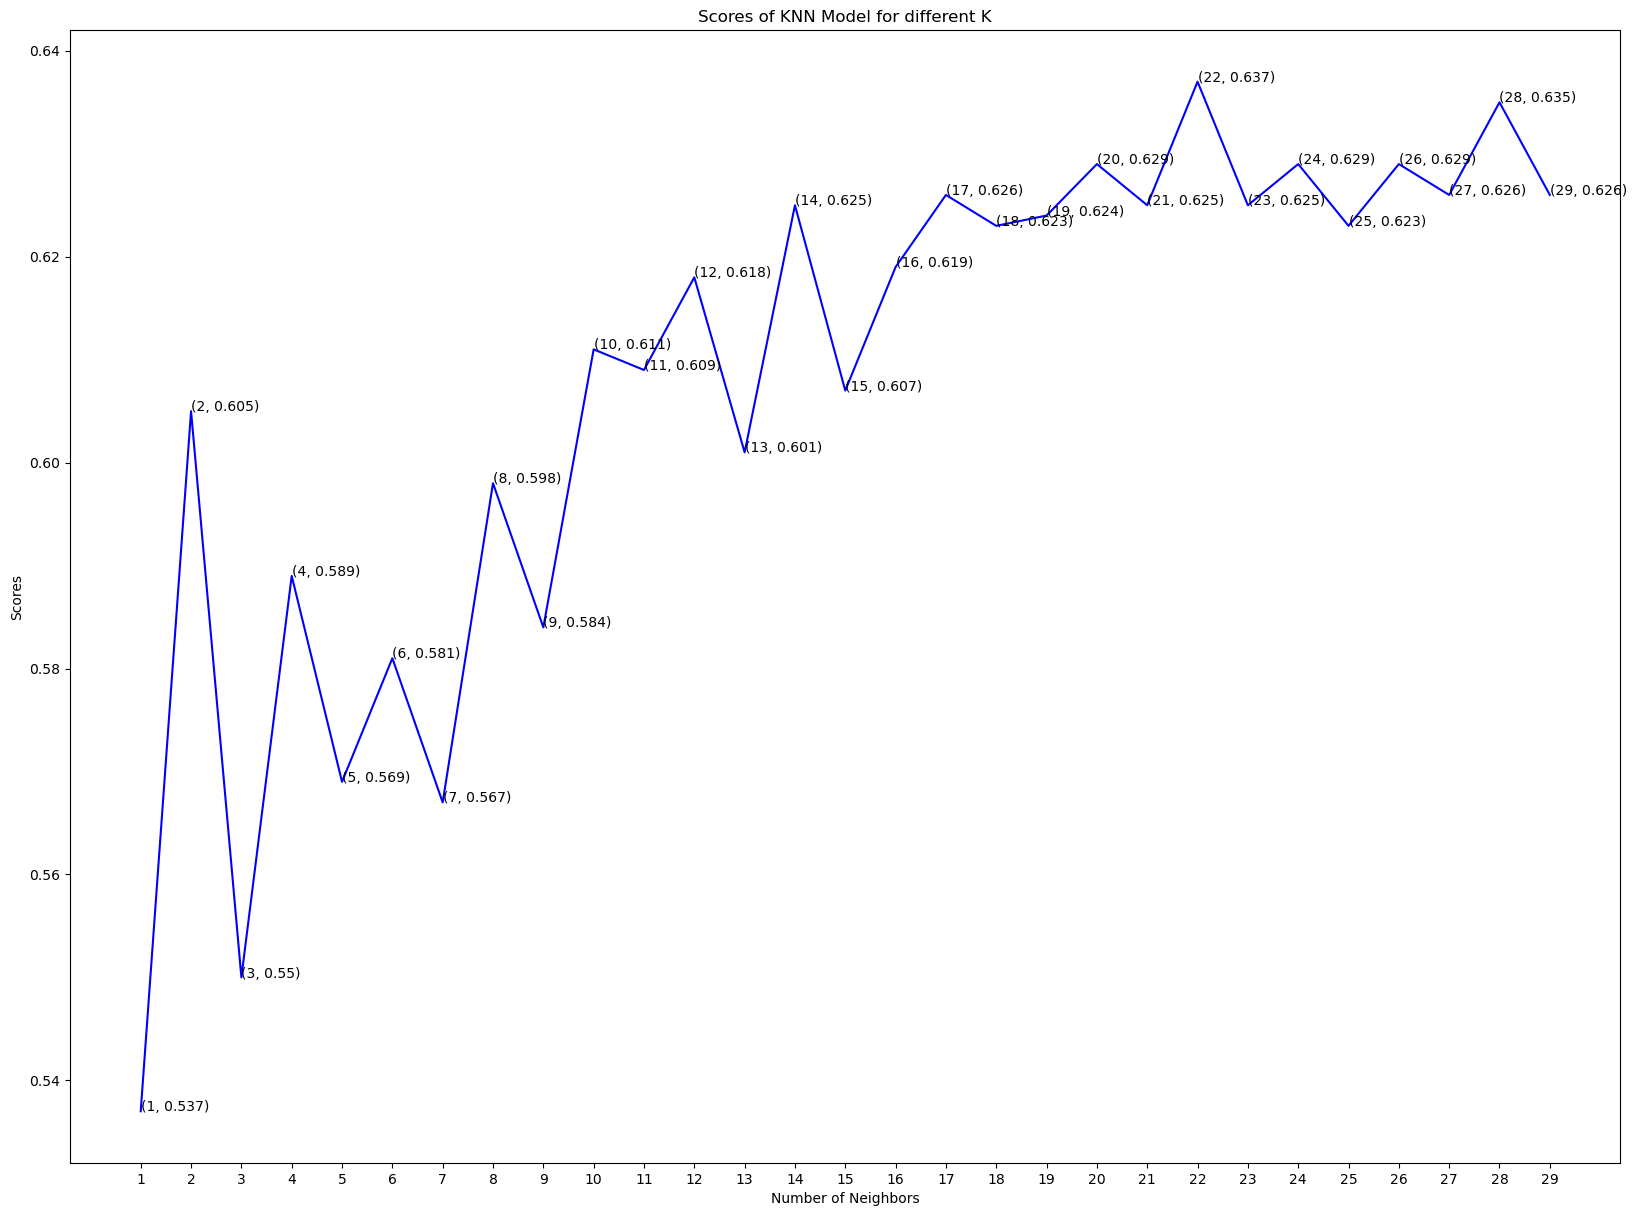

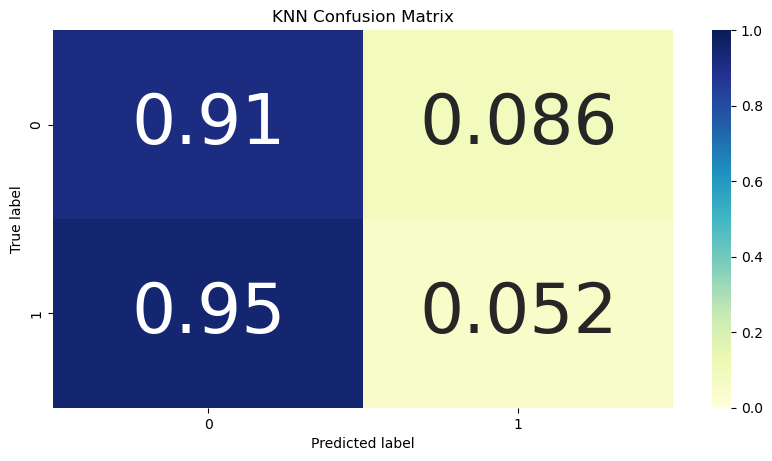

In [42]:
knn_4_proba = knn(X_train_4, X_test_4, y_train_4, y_test_4)

Best K:  28
The train accuracy score 0.675858732462506
The test accuracy score 0.6687358916478555

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1191
           1       0.31      0.01      0.02       581

    accuracy                           0.67      1772
   macro avg       0.49      0.50      0.41      1772
weighted avg       0.55      0.67      0.54      1772



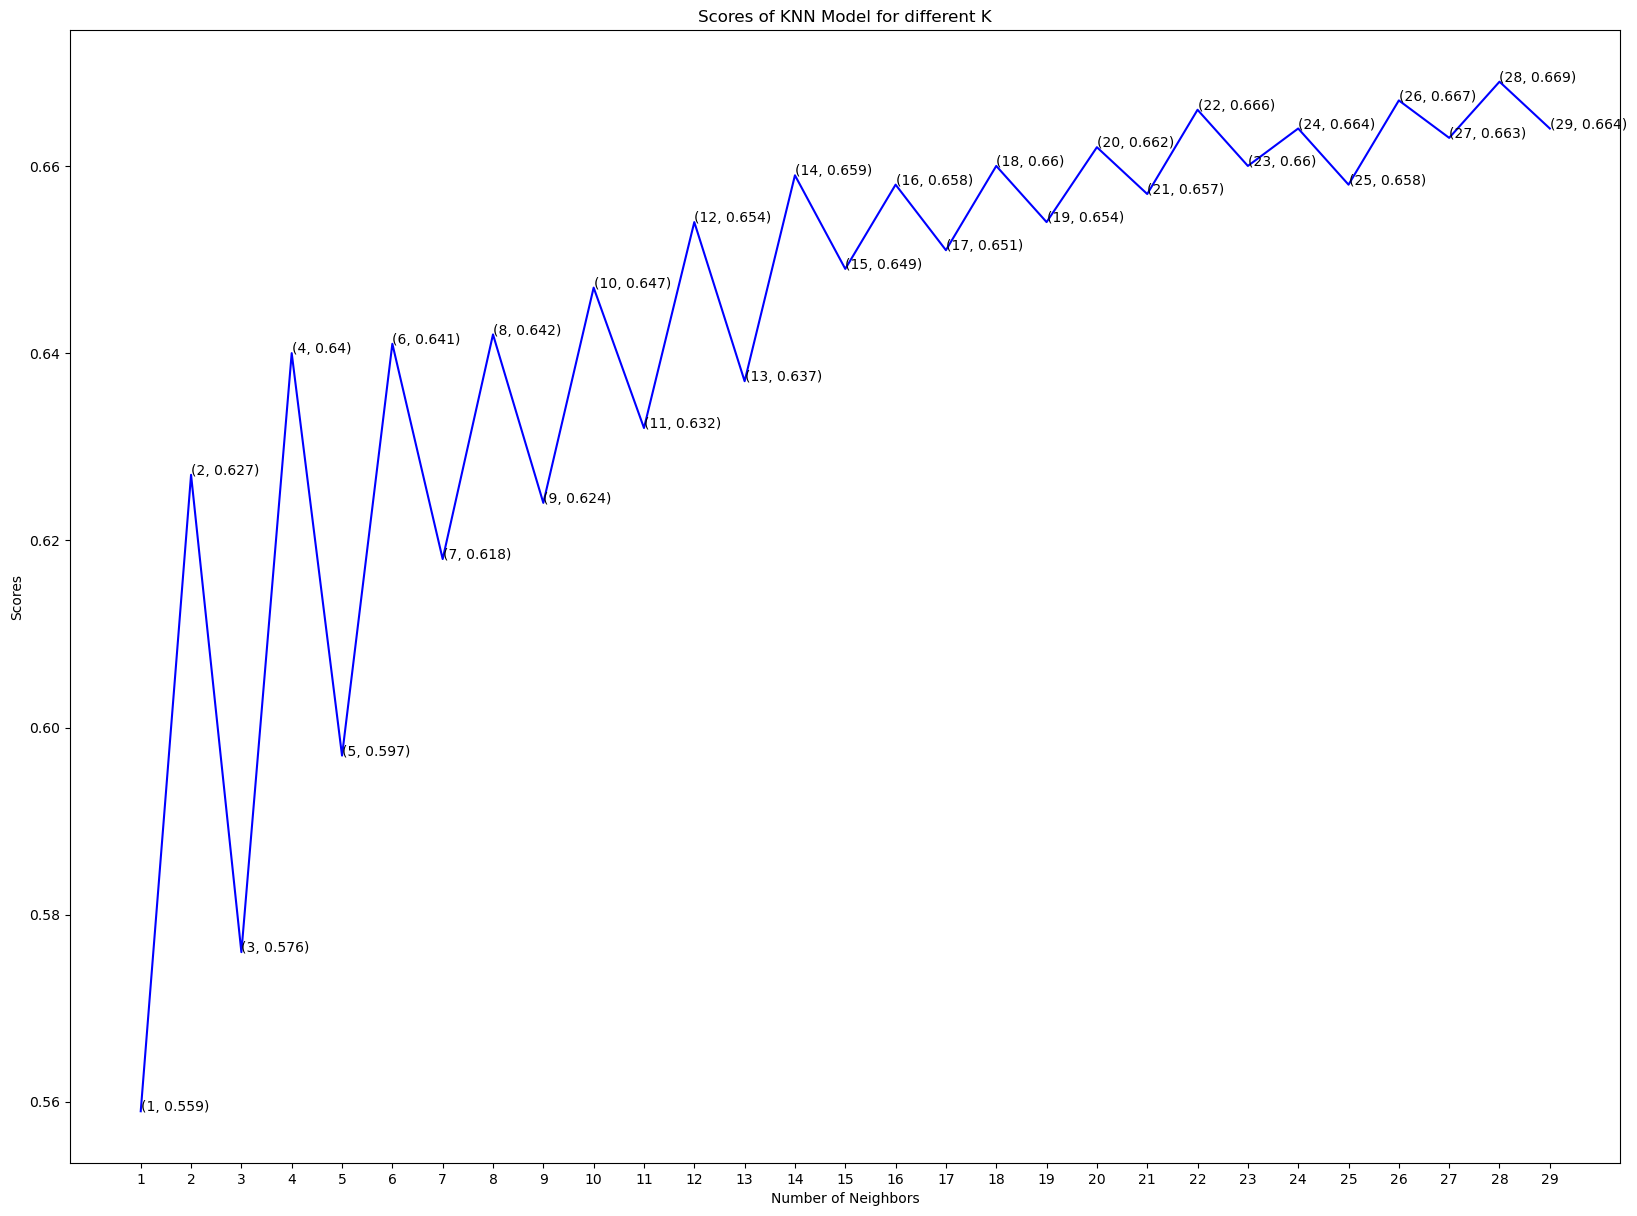

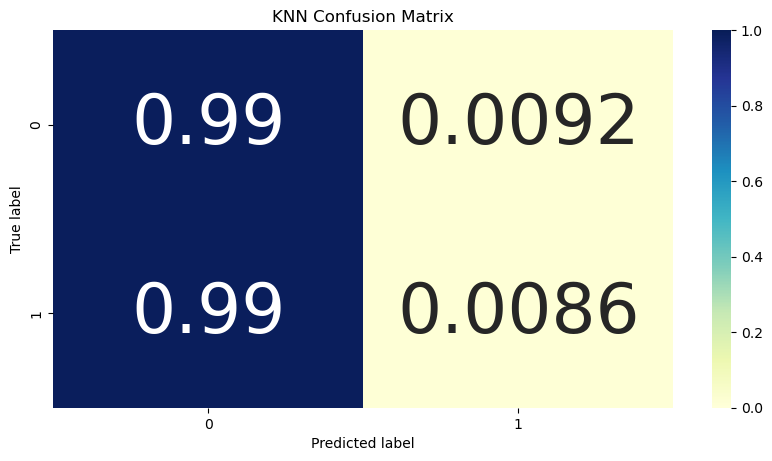

In [43]:
knn_5_proba = knn(X_train_5, X_test_5, y_train_5, y_test_5)

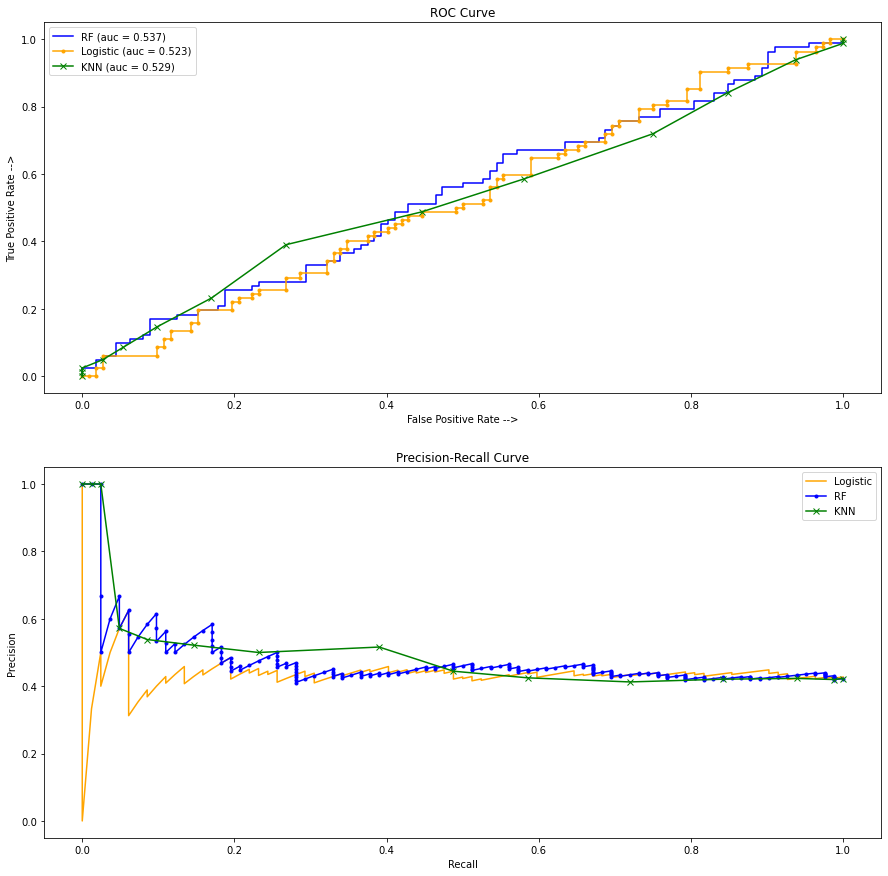

In [52]:
roccurve(y_test_3, log_reg_3_proba, rand_forest_3_proba, knn_3_proba)

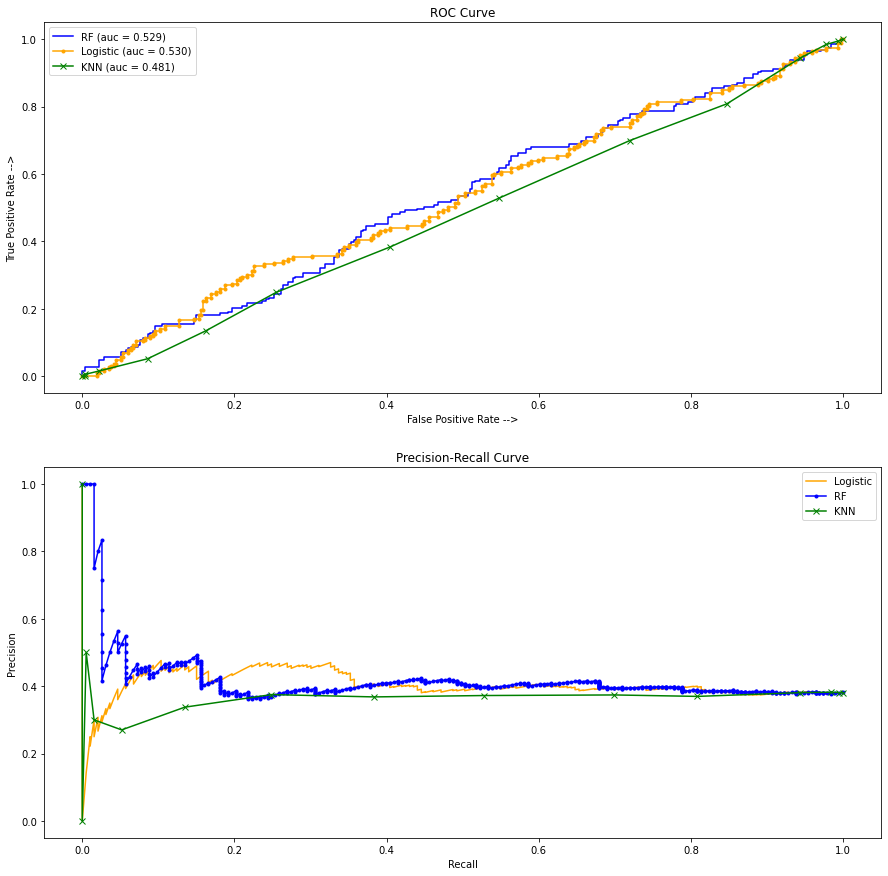

In [53]:
roccurve(y_test_4, log_reg_4_proba, rand_forest_4_proba, knn_4_proba)

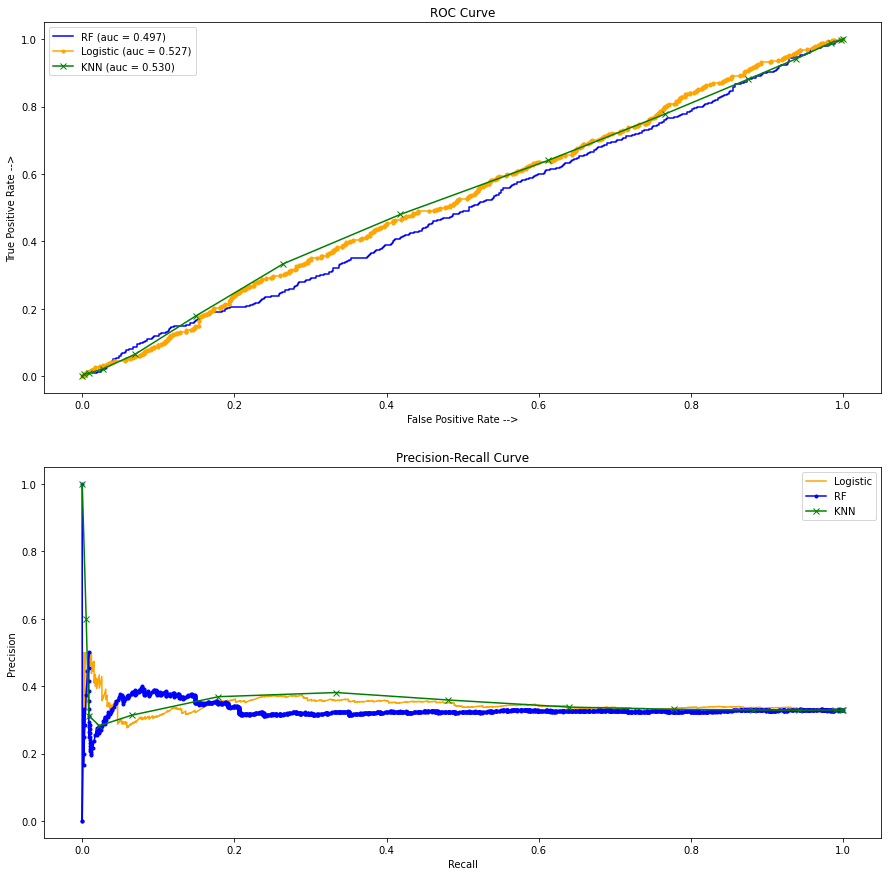

In [54]:
roccurve(y_test_5, log_reg_5_proba, rand_forest_5_proba, knn_5_proba)